# Stock Return Prediction and Portfolio Optimization
**Authors**
- Jingyi Fan, jf4258@nyu.edu, N15191508
- Tianyu Li, tl3472@nyu.edu, N18586573
- Wenxin Zhang, wz2127@nyu.edu, N15067695

**Abstract**

We select stock prices of Apple Inc. (AAPL), IBM, and Amazon.com, Inc. (AMZN) and apply machine learning models (i.e. 1D CNN, Simple RNN, LSTM, and GRU) to find the best fitted time series forecasting models for a single time step. We apply the Monte Carlo simulation method and calculate the Sharpe ratio to find the most optimal assignment of portfolio weights. Finally, we apply the estimated weights and predicted stock return to calculate the portfolio return for the next day.

# Introduction
There’s a widespread assumption in investing that higher risk equals increased potential returns. Thus, the main goal for investors is to find the optimal weights for each asset and predict the most substantial possible return given a specific portfolio. In this project, our aim is to use different financial stock prices from Yahoo Finance to find best fitted time series forecasting Models for a single time step. The specific models we employ are CNN, Simple RNN, LSTM and GRU that we've been exposed to during this class. 

Our project could be divided into three parts:
1. Using time series data and the WindowGenerator class, we could predict 1 step further and find the best fitted model by measuring and comparing the model’s performance.
2. Analyze the best investment portfolio via Monte Carlo Simulation and choose the optimal asset allocation with the selected stocks.
3. We combine the results from part 1 and 2 and derive the optimal return in the 1 step further.

## Import Packages and Download Data
First, we import the required libraries and acquire the data from [Yahoo Finance](https://finance.yahoo.com/)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as keras
from keras import layers as layers
import seaborn as sns
import datetime
from pandas_datareader import data as web

%matplotlib inline

We use `pandas_datareader` to import stock daily prices from finance yahoo with the date from 2015-01-01 until 2022-05-16, which is a total of 1856 days. In this project, we mainly focus on three financial stock prices: Apple Inc. (`aapl`), IBM (`ibm`) and Amazon.com, Inc. (`amzn`). For each stock, we obtain the following data:

- `High`: daily highest stock price
- `Low`: daily highest close price
- `Open`: daily open price
- `Close`: daily close price
- `Volume`: daily number of traded stock shares
- `Adj Close`: daily adjusted close price

We use `‘Adj Close’` of each stock for our analysis and visualize them in the following graphs.

In [2]:
start= datetime.datetime(2015,1,1)
end= datetime.datetime(2022,5,16)

aapl = web.DataReader('AAPL', 'yahoo', start, end)
ibm = web.DataReader('IBM', 'yahoo', start, end)
amzn = web.DataReader('AMZN', 'yahoo', start, end)

Text(0.5, 1.0, 'AMZN')

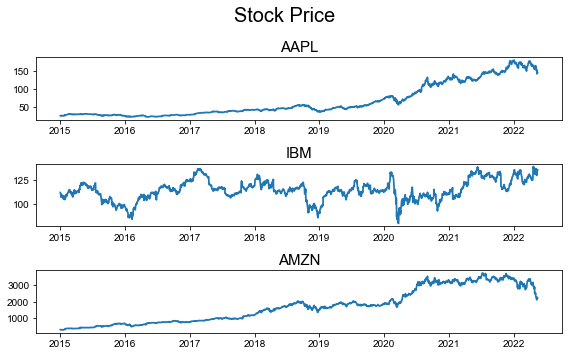

In [3]:
fig, axs = plt.subplots(3,1,sharey=False, tight_layout=True,figsize=(8, 5))
fig.suptitle('Stock Price', fontsize=20)
plt.style.use('seaborn')

axs[0].plot(aapl['Adj Close'])
axs[0].set_title('AAPL', size = 15)
axs[1].plot(ibm['Adj Close'])
axs[1].set_title('IBM', size = 15)
axs[2].plot(amzn['Adj Close'])
axs[2].set_title('AMZN', size = 15)

## Data Preparation
We define the return for each stock as the differences of logged prices of two consecutive trading days.

In [4]:
# Extract the adjusted closing price of each stock
df_aapl=pd.DataFrame(aapl["Adj Close"])
df_ibm=pd.DataFrame(ibm["Adj Close"])
df_amzn=pd.DataFrame(amzn["Adj Close"])

# Calculate Return
diff = lambda x: x.diff(1)
log_diff = lambda x: 100*np.log(x).diff(1)

df_aapl = df_aapl.transform({"Adj Close": log_diff}).dropna()
df_ibm = df_ibm.transform({"Adj Close": log_diff}).dropna()
df_amzn = df_amzn.transform({"Adj Close": log_diff}).dropna()

# Combine returns of each stock to a dataframe
stock_return=pd.concat([df_aapl,df_ibm,df_amzn],axis=1)
stock_return.describe()

,Adj Close,Adj Close,Adj Close
count,1855.000000,1855.000000,1855.000000
mean,0.095662,0.009995,0.106295
std,1.846950,1.569365,1.988347
min,-13.770813,-13.754767,-15.139797
25%,-0.698596,-0.648771,-0.793083
50%,0.089284,0.048866,0.121415
75%,1.018963,0.716244,1.070103
max,11.315764,10.706821,13.217792


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-lev

[Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'AMZN Daily Returns Distribution'),
 Text(0.5, 0, 'Returns')]

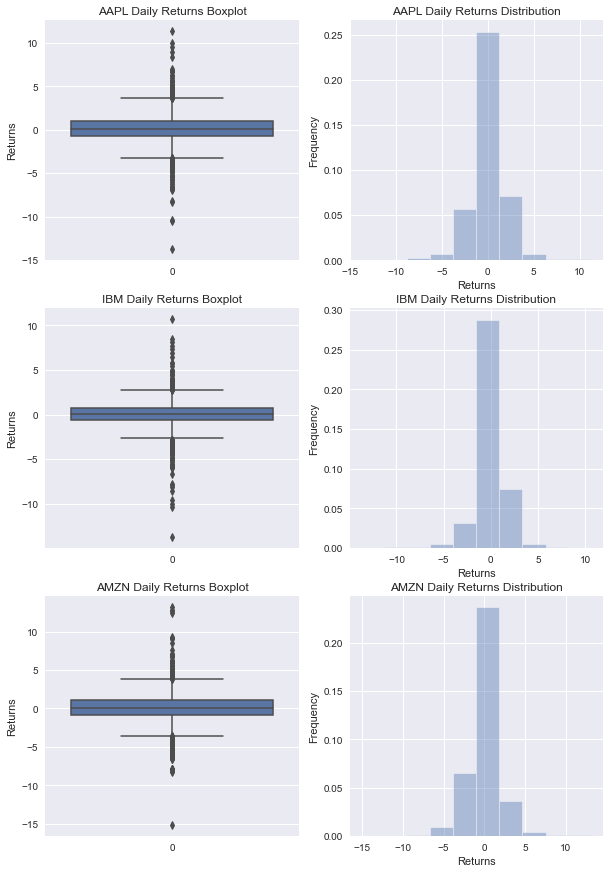

In [5]:
fig, ax = plt.subplots(ncols=2,nrows=3,figsize=(10,15))
sns.set(style="whitegrid", font_scale=1)

# AAPL Boxplot
image1 = sns.boxplot(data=df_aapl['Adj Close'], orient='v',ax=ax[0,0])
image1.set(ylabel='Returns', title='AAPL Daily Returns Boxplot')

# AAPL Distribution
image2 = sns.distplot(df_aapl['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[0,1])
image2.set(ylabel='Frequency', title='AAPL Daily Returns Distribution',xlabel='Returns')

# IBM Boxplot
image3 = sns.boxplot(data=df_ibm['Adj Close'], orient='v',ax=ax[1,0])
image3.set(ylabel='Returns', title='IBM Daily Returns Boxplot')

# IBM Distribution
image4 = sns.distplot(df_ibm['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[1,1])
image4.set(ylabel='Frequency', title='IBM Daily Returns Distribution',xlabel='Returns')

# AMZN Boxplot
image5 = sns.boxplot(data=df_amzn['Adj Close'], orient='v',ax=ax[2,0])
image5.set(ylabel='Returns', title='AMZN Daily Returns Boxplot')

# AMZN Distribution
image6 = sns.distplot(df_amzn['Adj Close'],kde=False,norm_hist=True,bins=10,ax=ax[2,1])
image6.set(ylabel='Frequency', title='AMZN Daily Returns Distribution',xlabel='Returns')

As we can see from the above data frame and graphs, the daily returns and volumes of each stock are centered around 0, suggesting mean-reversion of returns.

## Train-Test-Split
We use a (70%, 20%, 10%) split for the train, validation and test sets, and visualize them in the following graphs.

In [6]:
##############
#### AAPL ####
##############
n = df_aapl.shape[0]

# Training data
train_n = int(n*0.7)
train_df_aapl = df_aapl.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_aapl = df_aapl.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_aapl = df_aapl.iloc[train_n+val_n:, :]


##############
#### IBM #####
##############
n = df_ibm.shape[0]

# Training data
train_n = int(n*0.7)
train_df_ibm = df_ibm.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_ibm = df_ibm.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_ibm = df_ibm.iloc[train_n+val_n:, :]


##############
#### AMZN ####
##############
n = df_amzn.shape[0]

# Training data
train_n = int(n*0.7)
train_df_amzn = df_amzn.iloc[0:train_n, :]

# Validation data
val_n = int(n*0.2)
val_df_amzn = df_amzn.iloc[train_n:train_n+val_n, :]

# Testing data
test_df_amzn = df_amzn.iloc[train_n+val_n:, :]

<AxesSubplot:xlabel='Date'>

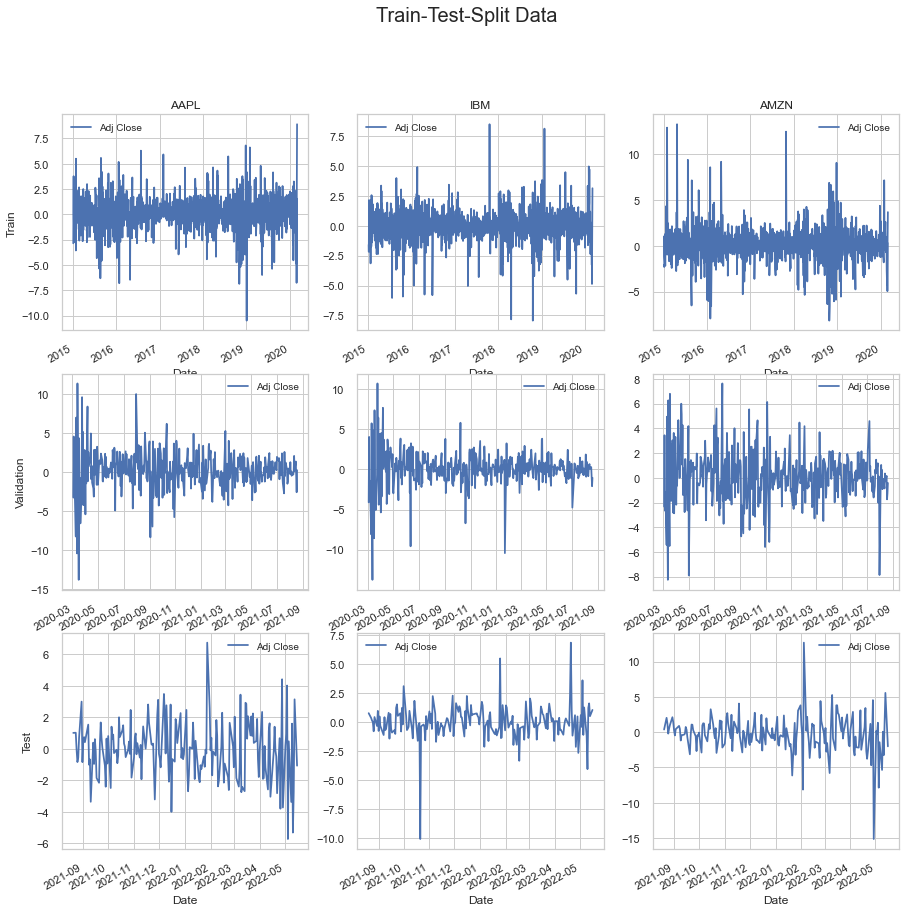

In [7]:
# Visualize train-test-split data for each stock
fig, ax = plt.subplots(ncols=3,nrows=3,figsize=(15,15))
fig.suptitle('Train-Test-Split Data', fontsize=20)
plt.style.use('seaborn')
# Train data
train_df_aapl.plot(y="Adj Close",ax=ax[0,0], title="AAPL",ylabel='Train')
train_df_ibm.plot(y="Adj Close",ax=ax[0,1], title="IBM")
train_df_amzn.plot(y="Adj Close",ax=ax[0,2], title="AMZN")
# Validation data
val_df_aapl.plot(y="Adj Close",ax=ax[1,0],ylabel='Validation')
val_df_ibm.plot(y="Adj Close",ax=ax[1,1])
val_df_amzn.plot(y="Adj Close",ax=ax[1,2])
# Test data
test_df_aapl.plot(y="Adj Close",ax=ax[2,0],ylabel='Test')
test_df_ibm.plot(y="Adj Close",ax=ax[2,1])
test_df_amzn.plot(y="Adj Close",ax=ax[2,2])

# Part 1: Return Prediction
In light by Lecture 16, we use different machine learning models (i.e. CNN, Simple RNN, LSTM, GRU) to predict future returns for each selected stock. We select the best fitted machine learning model for each stock based on their test and validation performances.

Following the ideas in https://www.tensorflow.org/tutorials/structured_data/time_series and Lecture note 16, we use the helpers below to:
- generate data windows with pairs of input and output sets
- plot the splitted windows
- generate batches of windows used for train, test, and validation sets

Note that in our project, we use the rolling window method with shifting the window forward by 1 day when generating data windows.

In [8]:
class WindowGenerator():

    def __init__(
        self, input_width, label_width, shift,
        train_df, val_df, test_df,
        label_columns=None
    ):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {
                name: i for i, name in enumerate(label_columns)
            }
        self.column_indices = {
            name: i for i, name in enumerate(train_df.columns)
        }

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def __repr__(self):
        return '\n'.join(
            [
                f'Total window size: {self.total_window_size}',
                f'Input indices: {self.input_indices}',
                f'Label indices: {self.label_indices}',
                f'Label column name(s): {self.label_columns}'
            ]
        )

    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [
                    labels[:, :, self.column_indices[name]]
                    for name in self.label_columns
                ], axis=-1
            )

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Adj Close', max_subplots=3):
    
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col}')
            plt.plot(
                self.input_indices,
                inputs[n, :, plot_col_index],
                label='Inputs', marker='.', zorder=-10
            )

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', label='Labels', c='#2ca02c', s=64)

            if model is not None:
                predictions = model(inputs)
                plt.scatter(
                    self.label_indices, predictions[n, :, 0],
                    marker='X', edgecolors='k', label='Predictions',
                    c='#ff7f0e', s=64
                )

            if n == 0:
                plt.legend()

        plt.xlabel('Months')


    def make_prediction(self, model):
        """ return the predicted return for tomorrow """
        inputs,  = self.example
        predictions = model(inputs)
        return predictions[len(inputs)-1, :, 0].numpy()[-1]


    def prediction_plot(self, model, plot_col='Adj Close'):
        """ plot only the last rolling window """
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        n = len(inputs)-1

        plt.ylabel(f'{plot_col}')
        plt.plot(
            self.input_indices,
            inputs[n, :, plot_col_index],
            label='Inputs', marker='.', zorder=-10
        )

        if self.label_columns:
            label_col_index = self.label_columns_indices.get(plot_col, None)
        else:
            label_col_index = plot_col_index

        plt.scatter(self.label_indices, labels[n, :, label_col_index],
                    edgecolors='k', label='Labels', c='#2ca02c', s=64)

        predictions = model(inputs)
        plt.scatter(
            self.label_indices, predictions[n, :, 0],
            marker='X', edgecolors='k', label='Predictions',
            c='#ff7f0e', s=64
        )

        plt.xlabel('Months')
    

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=22,
        )

        ds = ds.map(self.split_window)

        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result

        return result

We use AAPL stock as an example to demonstrate our reasoning behind model selection.

## AAPL

Because we are dealing with daily stock data, we define `INPUT_WIDTH` as `22` and `LABEL_WIDTH` as `1`, so that we use stock returns of the last month (22 trading days) to predict returns of the next day.

In [9]:
INPUT_WIDTH = 22
LABEL_WIDTH = 1
SHIFT = 1 # Again, we shift our window by 1 day

eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
    shift=SHIFT, label_columns=["Adj Close"]
)

In [10]:
MAX_EPOCHS = 250

def compile_and_fit(model, window, patience=5):

    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        mode='min'
    )

    model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.RMSprop(),
    )


    history = model.fit(
        window.train, epochs=MAX_EPOCHS,
        validation_data=window.val,
        callbacks=[early_stopping]
    )

    return history

### Baseline Model

Before we start to build different types of models in our project, it would be good to find the simplest model that serves as benchmarks for trained models. Our first task is to establish a baseline model in the project as a reference to the other machine learning models.
For simplicity, we assume the return of a stock is mean-reverting and changes slowly. Thus, we can start with a model that just gives the current returns as the prediction, predicting "No change".

Our baseline model:

Make the prediction as the previous value:

$$\pi_t = \pi_{t-1}$$

In [11]:
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [12]:
baseline_aapl = Baseline(label_index=eval_window.column_indices["Adj Close"])
baseline_aapl.compile(loss=tf.losses.MeanSquaredError())

val_performance_aapl = {}
performance_aapl = {}

val_performance_aapl['Baseline'] = baseline_aapl.evaluate(eval_window.val)
performance_aapl['Baseline'] = baseline_aapl.evaluate(eval_window.test, verbose=0)

16/16 [==============================] - 0s 743us/step - loss: 9.7716


### 1D CNN

We first adopt a 1D Convolution (CNN) model. An 1D CNN model takes a fixed-width data history to make a single prediction. A convolutional layer process and convolve layer inputs locally, and slides the local window to compute the next output. Therefore, the CNN model is extremely powerful in recognizing repeated patterns, which is especially useful when analyzing time series data.

![1d_cnn_visual.jpg](1d_cnn_visual.jpg)

Given hyper parameters,

* $K$: Number of filters
* $F$: Window width
* $S$: Stride
* $P$: Padding

Let $w \in \mathbb{R}^K$ be the filter weights and $b \in \mathbb{R}$ be the bias, output $i$ for a particular filter is defined by:

$$z_i = \left( \sum_{j=0}^F w_{j} x_{i + j - F//2} \right) + b$$

In [13]:
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_aapl, val_df=val_df_aapl, test_df=test_df_aapl,
    label_width=1,
    shift=1
)

conv_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=16, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=8, activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_aapl, conv_window)

val_performance_aapl['Conv1D'] = conv_model_aapl.evaluate(eval_window.val)
performance_aapl['Conv1D'] = conv_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 1s 4ms/step - loss: 2.5609 - val_loss: 4.4411
Epoch 2/250
58/58 [==============================] - 0s 3ms/step - loss: 2.5235 - val_loss: 4.3930
Epoch 3/250
58/58 [==============================] - 0s 3ms/step - loss: 2.4983 - val_loss: 4.3788
Epoch 4/250
58/58 [==============================] - 0s 3ms/step - loss: 2.4774 - val_loss: 4.3789
Epoch 5/250
58/58 [==============================] - 0s 2ms/step - loss: 2.4548 - val_loss: 4.3906
Epoch 6/250
58/58 [==============================] - 0s 2ms/step - loss: 2.4289 - val_loss: 4.4308
Epoch 7/250
58/58 [==============================] - 0s 5ms/step - loss: 2.4081 - val_loss: 4.4660
Epoch 8/250
16/16 [==============================] - 0s 1ms/step - loss: 4.4872


### Simple RNN

Then we consider a basic version of an RNN model, simple RNN, as the second trainable model in the project. The RNN model is a type of neural network well-suited to time series data, which could process a time series step-by-step. At each time step t, the RNN model gets the inputs x(t) in addition to its personal output from the preceding time step. This form of sequence-to-sequence network is useful for predicting time collection which includes stock prices and returns.

Based on the graph, the output for step $t+1$ is given by:

\begin{align*}
  h_{t+1} &= \sigma_h(W_x x_t + W_h h_t + b_h) \\
  y_{t+1} &= \sigma_y(W_{y} h_{t+1} + b_y) \\
\end{align*}

![simple_RNN.png](simple_RNN.png)

In [14]:
srnn_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_aapl, eval_window)

val_performance_aapl['SimpleRNN'] = srnn_model_aapl.evaluate(eval_window.val)
performance_aapl['SimpleRNN'] = srnn_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 1s 6ms/step - loss: 2.6097 - val_loss: 4.3608
Epoch 2/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5570 - val_loss: 4.3748
Epoch 3/250
58/58 [==============================] - 0s 5ms/step - loss: 2.5416 - val_loss: 4.3797
Epoch 4/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5376 - val_loss: 4.3797
Epoch 5/250
58/58 [==============================] - 0s 4ms/step - loss: 2.5318 - val_loss: 4.3828
Epoch 6/250
16/16 [==============================] - 0s 2ms/step - loss: 4.3798


### LSTM

It has been proposed that the Long Short-Term Memory (LSTM) model and the Gated Recurrent Unit (GRU) model can be solutions to the vanishing gradient problem and exploding gradient problem of traditional RNN models.

In the LSTM model, output for step $t$ is now given by:

$$h_t = \sigma_h(W_h x_t + U_h h_{t-1} + V_h c_t + b_h)$$

where $c_t$, the "carry state", is computed with

\begin{align*}
  c_{t+1} &= i_t k_t + c_t f_t \\
  i_t &= \sigma(U_i \hat{x}_{t} + W_i x_t + b_i) \\
  f_t &= \sigma(U_f \hat{x}_{t} + W_f x_t + b_f) \\
  k_t &= \sigma(U_k \hat{x}_{t} + W_k x_t + b_k) \\
\end{align*}


In [15]:
lstm_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_aapl, eval_window)

val_performance_aapl['LSTM'] = lstm_model_aapl.evaluate(eval_window.val)
performance_aapl['LSTM'] = lstm_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 2s 9ms/step - loss: 2.5569 - val_loss: 4.3405
Epoch 2/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5511 - val_loss: 4.3037
Epoch 3/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5485 - val_loss: 4.3179
Epoch 4/250
58/58 [==============================] - 0s 6ms/step - loss: 2.5462 - val_loss: 4.3062
Epoch 5/250
58/58 [==============================] - 1s 8ms/step - loss: 2.5446 - val_loss: 4.3029
Epoch 6/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5445 - val_loss: 4.3053
Epoch 7/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5398 - val_loss: 4.3051
Epoch 8/250
58/58 [==============================] - 0s 6ms/step - loss: 2.5401 - val_loss: 4.2998
Epoch 9/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5406 - val_loss: 4.3080
Epoch 10/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5389 - val_loss: 4.2960
Epoch 11/

### GRU

The last model we apply is the Gated Recurrent Unit (GRU) model. Gated Recurrent Unit model can be used to improve the memory capacity of a RNN model while providing the ease of training a model which adjusts the input weights to solve the vanishing gradient problem. It is less complex than LSTM because it has fewer gates.

Output for step $t$ is given by:

\begin{align*}
  z_t &= \sigma_g(W_z x_t + U_z h_{t-1} + b_z) \\
  r_t &= \sigma_g(W_r x_t + U_r h_{t-1} + b_r) \\
  \hat{h}_t &= \phi_h(W_h x_t + U_h (r_t \odot h_{t-1}) + b_h) \\
  h_t &= (1 - z_t) \odot h_{t-1} + z_t \odot \hat{h}_{t}
\end{align*}

In [16]:
gru_model_aapl = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_aapl, eval_window)

val_performance_aapl['GRU'] = gru_model_aapl.evaluate(eval_window.val)
performance_aapl['GRU'] = gru_model_aapl.evaluate(eval_window.test, verbose=0)

Epoch 1/250
58/58 [==============================] - 2s 11ms/step - loss: 2.5991 - val_loss: 4.3855
Epoch 2/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5733 - val_loss: 4.3607
Epoch 3/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5622 - val_loss: 4.3429
Epoch 4/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5564 - val_loss: 4.3305
Epoch 5/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5503 - val_loss: 4.3248
Epoch 6/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5467 - val_loss: 4.3158
Epoch 7/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5446 - val_loss: 4.3111
Epoch 8/250
58/58 [==============================] - 0s 8ms/step - loss: 2.5411 - val_loss: 4.3015
Epoch 9/250
58/58 [==============================] - 1s 9ms/step - loss: 2.5397 - val_loss: 4.3008
Epoch 10/250
58/58 [==============================] - 0s 7ms/step - loss: 2.5385 - val_loss: 4.2988
Epoch 11

### Performance

In [17]:
performance_aapl

{'Baseline': 6.656155586242676,
 'Conv1D': 3.5217084884643555,
 'SimpleRNN': 3.655221700668335,
 'LSTM': 3.5980236530303955,
 'GRU': 3.5445988178253174}

In [18]:
val_performance_aapl

{'Baseline': 9.771610260009766,
 'Conv1D': 4.487193584442139,
 'SimpleRNN': 4.3797502517700195,
 'LSTM': 4.30236291885376,
 'GRU': 4.2873005867004395}

## IBM

In [19]:
eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_ibm, val_df=val_df_ibm, test_df=test_df_ibm,
    shift=SHIFT, label_columns=["Adj Close"]
)


####################
##### Baseline #####
####################
baseline_ibm = Baseline(label_index=eval_window.column_indices["Adj Close"])
baseline_ibm.compile(loss=tf.losses.MeanSquaredError())

val_performance_ibm = {}
performance_ibm = {}

val_performance_ibm['Baseline'] = baseline_ibm.evaluate(eval_window.val)
performance_ibm['Baseline'] = baseline_ibm.evaluate(eval_window.test, verbose=0)




####################
####### CNN ########
####################
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_ibm, val_df=val_df_ibm, test_df=test_df_ibm,
    label_width=1,
    shift=1
)

conv_model_ibm = tf.keras.Sequential(
    [tf.keras.layers.Conv1D(filters=16, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=8, activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_ibm, conv_window)

val_performance_ibm['Conv1D'] = conv_model_ibm.evaluate(eval_window.val)
performance_ibm['Conv1D'] = conv_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### RNN ########
####################
srnn_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_ibm, eval_window)

val_performance_ibm['SimpleRNN'] = srnn_model_ibm.evaluate(eval_window.val)
performance_ibm['SimpleRNN'] = srnn_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### LSTM #######
####################
lstm_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_ibm, eval_window)

val_performance_ibm['LSTM'] = lstm_model_ibm.evaluate(eval_window.val)
performance_ibm['LSTM'] = lstm_model_ibm.evaluate(eval_window.test, verbose=0)



####################
####### GRU ########
####################
gru_model_ibm = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_ibm, eval_window)

val_performance_ibm['GRU'] = gru_model_ibm.evaluate(eval_window.val)
performance_ibm['GRU'] = gru_model_ibm.evaluate(eval_window.test, verbose=0)


16/16 [==============================] - 0s 796us/step - loss: 7.5765
Epoch 1/250
58/58 [==============================] - 1s 4ms/step - loss: 1.7656 - val_loss: 3.2140
Epoch 2/250
58/58 [==============================] - 0s 3ms/step - loss: 1.7226 - val_loss: 3.2066
Epoch 3/250
58/58 [==============================] - 0s 2ms/step - loss: 1.7024 - val_loss: 3.2067
Epoch 4/250
58/58 [==============================] - 0s 3ms/step - loss: 1.6845 - val_loss: 3.2099
Epoch 5/250
58/58 [==============================] - 0s 3ms/step - loss: 1.6696 - val_loss: 3.2163
Epoch 6/250
58/58 [==============================] - 0s 2ms/step - loss: 1.6566 - val_loss: 3.2215
Epoch 7/250
16/16 [==============================] - 0s 886us/step - loss: 3.2377
Epoch 1/250
58/58 [==============================] - 1s 7ms/step - loss: 1.7859 - val_loss: 3.2743
Epoch 2/250
58/58 [==============================] - 0s 4ms/step - loss: 1.7457 - val_loss: 3.2274
Epoch 3/250
58/58 [==============================] - 0s 

In [20]:
performance_ibm

{'Baseline': 4.591808795928955,
 'Conv1D': 2.405503034591675,
 'SimpleRNN': 2.402758836746216,
 'LSTM': 2.3930184841156006,
 'GRU': 2.4064013957977295}

In [21]:
val_performance_ibm

{'Baseline': 7.576462745666504,
 'Conv1D': 3.237736940383911,
 'SimpleRNN': 3.1842639446258545,
 'LSTM': 3.1501870155334473,
 'GRU': 3.1446688175201416}

## AMZN

In [22]:
eval_window = WindowGenerator(
    input_width=INPUT_WIDTH, label_width=LABEL_WIDTH,
    train_df=train_df_amzn, val_df=val_df_amzn, test_df=test_df_amzn,
    shift=SHIFT, label_columns=["Adj Close"],
)

####################
##### Baseline #####
####################
baseline_amzn = Baseline(label_index=eval_window.column_indices["Adj Close"])
baseline_amzn.compile(loss=tf.losses.MeanSquaredError())

val_performance_amzn = {}
performance_amzn = {}

val_performance_amzn['Baseline'] = baseline_amzn.evaluate(eval_window.val)
performance_amzn['Baseline'] = baseline_amzn.evaluate(eval_window.test, verbose=0)



####################
####### CNN ########
####################
CONV_WIDTH = 22

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    train_df=train_df_amzn, val_df=val_df_amzn, test_df=test_df_amzn,
    label_width=1,
    shift=1
)

conv_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.Conv1D(filters=16, kernel_size=(CONV_WIDTH,), activation="relu"),
        tf.keras.layers.Dense(units=8, activation="relu"),
        tf.keras.layers.Dense(units=4, activation="relu"),
        tf.keras.layers.Dense(units=1),
    ]
)

compile_and_fit(conv_model_amzn, conv_window)

val_performance_amzn['Conv1D'] = conv_model_amzn.evaluate(eval_window.val)
performance_amzn['Conv1D'] = conv_model_amzn.evaluate(eval_window.test, verbose=0)


####################
####### SRNN #######
####################
srnn_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.SimpleRNN(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(srnn_model_amzn, eval_window)

val_performance_amzn['SimpleRNN'] = srnn_model_amzn.evaluate(eval_window.val)
performance_amzn['SimpleRNN'] = srnn_model_amzn.evaluate(eval_window.test, verbose=0)



####################
####### LSTM #######
####################
lstm_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.LSTM(16, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(8),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
        tf.keras.layers.Activation('linear')
    ]
)

compile_and_fit(lstm_model_amzn, eval_window)

val_performance_amzn['LSTM'] = lstm_model_amzn.evaluate(eval_window.val)
performance_amzn['LSTM'] = lstm_model_amzn.evaluate(eval_window.test, verbose=0)



####################
####### GRU ########
####################
gru_model_amzn = tf.keras.Sequential(
    [
        tf.keras.layers.GRU(8, activation="relu", return_sequences=False),
        tf.keras.layers.Dense(4),
        tf.keras.layers.Dense(1),
    ]
)

compile_and_fit(gru_model_amzn, eval_window)

val_performance_amzn['GRU'] = gru_model_amzn.evaluate(eval_window.val)
performance_amzn['GRU'] = gru_model_amzn.evaluate(eval_window.test, verbose=0)

16/16 [==============================] - 0s 1ms/step - loss: 8.1478
Epoch 1/250
58/58 [==============================] - 1s 5ms/step - loss: 3.3637 - val_loss: 3.9622
Epoch 2/250
58/58 [==============================] - 0s 3ms/step - loss: 3.2346 - val_loss: 3.9289
Epoch 3/250
58/58 [==============================] - 0s 4ms/step - loss: 3.1836 - val_loss: 3.9203
Epoch 4/250
58/58 [==============================] - 0s 3ms/step - loss: 3.1459 - val_loss: 3.9247
Epoch 5/250
58/58 [==============================] - 0s 3ms/step - loss: 3.1142 - val_loss: 3.9287
Epoch 6/250
58/58 [==============================] - 0s 3ms/step - loss: 3.0824 - val_loss: 3.9386
Epoch 7/250
58/58 [==============================] - 0s 4ms/step - loss: 3.0479 - val_loss: 3.9458
Epoch 8/250
16/16 [==============================] - 0s 999us/step - loss: 3.9685
Epoch 1/250
58/58 [==============================] - 1s 6ms/step - loss: 3.5409 - val_loss: 4.0284
Epoch 2/250
58/58 [==============================] - 0s 5m

In [23]:
performance_amzn

{'Baseline': 13.558144569396973,
 'Conv1D': 7.45703649520874,
 'SimpleRNN': 7.878622531890869,
 'LSTM': 7.854033470153809,
 'GRU': 7.6793532371521}

In [24]:
val_performance_amzn

{'Baseline': 8.147785186767578,
 'Conv1D': 3.9685304164886475,
 'SimpleRNN': 3.9688737392425537,
 'LSTM': 3.8949294090270996,
 'GRU': 3.8853402137756348}

## Validation and Test Performance

We fitted five different models in the section above and summarize their validation and test performance shown in the following tables:

### Validation Performance df

In [25]:
val_aapl = pd.DataFrame.from_dict(val_performance_aapl, orient = 'index', columns=["aapl_val"])
val_ibm = pd.DataFrame.from_dict(val_performance_ibm, orient = 'index', columns=["ibm_val"])
val_amzn = pd.DataFrame.from_dict(val_performance_amzn, orient = 'index', columns=["amzn_val"])
val_df = pd.concat([val_aapl, val_ibm, val_amzn],axis=1)
val_df

,aapl_val,ibm_val,amzn_val
Baseline,9.771610,7.576463,8.147785
Conv1D,4.487194,3.237737,3.968530
SimpleRNN,4.379750,3.184264,3.968874
LSTM,4.302363,3.150187,3.894929
GRU,4.287301,3.144669,3.885340


### Test performance df

In [26]:
p_aapl = pd.DataFrame.from_dict(performance_aapl, orient = 'index', columns=["aapl_test"])
p_ibm = pd.DataFrame.from_dict(performance_ibm, orient = 'index', columns=["ibm_test"])
p_amzn = pd.DataFrame.from_dict(performance_amzn, orient = 'index', columns=["amzn_test"])
p_df = pd.concat([p_aapl, p_ibm, p_amzn],axis=1)
p_df

,aapl_test,ibm_test,amzn_test
Baseline,6.656156,4.591809,13.558145
Conv1D,3.521708,2.405503,7.457036
SimpleRNN,3.655222,2.402759,7.878623
LSTM,3.598024,2.393018,7.854033
GRU,3.544599,2.406401,7.679353


### Model Performance Visualization

<function matplotlib.pyplot.show(close=None, block=None)>

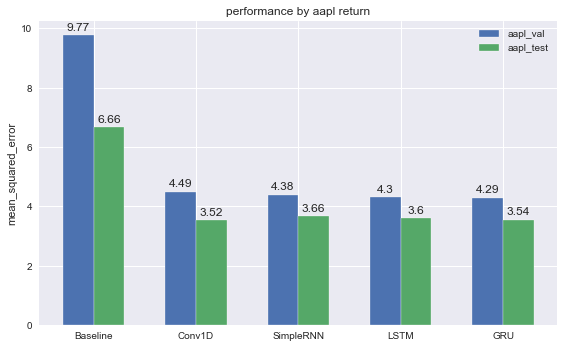

In [27]:
# AAPL

a=[]
for i in val_df['aapl_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['aapl_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_aapl))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='aapl_val')
rects2 = ax.bar(x + width/2, b,width, label='aapl_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by aapl return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> Generally, **1D CNN model** has an overall better performance in AAPL return.

<function matplotlib.pyplot.show(close=None, block=None)>

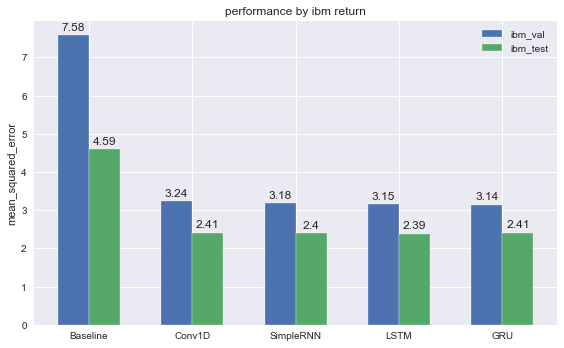

In [28]:
# IBM

a=[]
for i in val_df['ibm_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['ibm_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_ibm))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='ibm_val')
rects2 = ax.bar(x + width/2, b,width, label='ibm_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by ibm return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> **LSTM model** has a better performance in IBM return in most cases.

<function matplotlib.pyplot.show(close=None, block=None)>

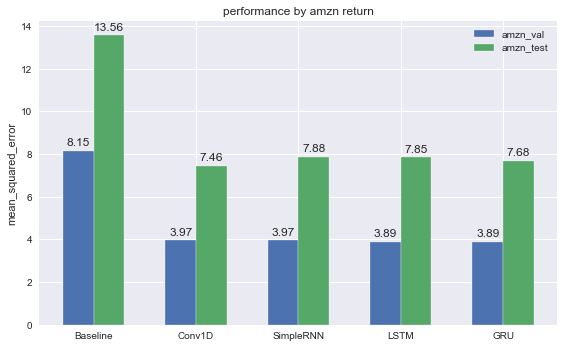

In [29]:
# AMZN

a=[]
for i in val_df['amzn_val'].to_list():
    a.append(round(i, 2))

b=[]
for i in p_df['amzn_test'].to_list():
    b.append(round(i, 2))

labels = ['Baseline','Conv1D','SimpleRNN','LSTM','GRU']
x = np.arange(len(performance_amzn))
width = 0.3

fig,ax = plt.subplots(figsize=(8, 5))
rects1 = ax.bar(x - width/2, a, width, label='amzn_val')
rects2 = ax.bar(x + width/2, b,width, label='amzn_test')

ax.set_ylabel('mean_squared_error')
ax.set_title('performance by amzn return')
plt.xticks(ticks=x, labels=labels,)
_ = plt.legend()
ax.legend()

ax.bar_label(rects1,padding=3)
ax.bar_label(rects2,padding=3)

fig.tight_layout()

plt.show

> **GRU model** is a better fit for AMZN stock return in general.

## Prediction

Using the selected models from the section above, we predict the stock returns for the next day. The selected models are:
- 1D CNN model for AAPL
- LSTM model for IBM
- GRU model for AMZN

We here define a function to extract the last window containing 22 days used for prediction.

In [30]:
def preprocess_testdat(data, test_df, window_size=22):    
    raw = data['Adj Close'][len(data) - len(test_df) - window_size:].values # locate the last window period
    raw = raw.reshape(-1,1)

    
    X_test = []
    for i in range(window_size, raw.shape[0]+1):
        X_test.append(raw[i-window_size:i, 0])
        
    X_test = np.array(X_test)
    
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1)) 
    return X_test

### AAPL Prediction

In [31]:
test_aapl = preprocess_testdat(df_aapl, test_df = test_df_aapl)
predict_aapl = conv_model_aapl.predict(test_aapl)[-1][0][0]
predict_aapl

0.1281769

### IBM Prediction

In [48]:
test_ibm = preprocess_testdat(df_ibm, test_df = test_df_ibm)
predict_ibm = lstm_model_ibm.predict(test_ibm)[-1][0]
predict_ibm

0.071315914

### AMZN Prediction

In [49]:
test_amzn = preprocess_testdat(df_amzn, test_df = test_df_amzn)
predict_amzn = gru_model_amzn.predict(test_amzn)[-1][0]
predict_amzn

-0.26168972

> Based on our prediction using the most fitted models, returns of selected stocks on 2022-05-17 should be:
- 0.13 for AAPL 
- 0.07 for IBM 
- -0.26 for AMZN 

# Part 2: Portfolio Optimization

In this part, we solve the portfolio optimization problem by using Monte Carlo simulation. Our portfolio includes the abovementioned stocks: aapl, ibm, and amzn. 

**Portfolio optimization** is the process of creating a portfolio of assets with different weights, for which our investment has the maximum return with minimum risk. And the sum of weights for each stock should be 1. Here, we take the natural logarithm of the price ratio of two consecutive days as return. And we use volatility to represent risk, which is the standard deviation of returns. The higher the volatility, the riskier the asset.

Our portfolio optimization process is based on the **Modern Portfolio Theory**, formulated by H. Markowitz. Modern Portfolio Theory (MPT), also known as mean-variance analysis, is a mathematical process that allows the user to maximize returns for a given risk level. MPT assumes that all investors are risk-averse, and encourages diversification of assets.

And to find the weights enabling our investment to reach the optimum, we use a **Monte Carlo Simulation**. Monte Carlo method is a stochastic (random sampling of inputs) method to solve a statistical problem. It focuses on constantly repeating random samples to achieve certain results. Here it assigns random values to the weights and computes the corresponding returns and volatilities. This process is repeated thousands of times, generating portfolios with different weights. And among the simulated portfolios, we find the weights yielding the optimum result.

## Returns and Volatilities of Individual Stock
First, we take a look at each individual stock in our portfolio. We compute the yearly returns and volatilities of each stock.

In [34]:
# Merge the adjusted closing price of the three stocks into one Dataframe
df1=pd.DataFrame(aapl["Adj Close"]).rename(columns={"Adj Close":"aapl"})
df2=pd.DataFrame(ibm["Adj Close"]).rename(columns={"Adj Close":"ibm"})
df3=pd.DataFrame(amzn["Adj Close"]).rename(columns={"Adj Close":"amzn"})
df=pd.concat([df1,df2,df3],axis=1)
df

,aapl,ibm,amzn
Date,,,
2015-01-02,24.678247,112.178055,308.519989
2015-01-05,23.983027,110.412971,302.190002
2015-01-06,23.985285,108.031792,295.290009
2015-01-07,24.321606,107.325775,298.420013
2015-01-08,25.256100,109.658501,300.459991
...,...,...,...
2022-05-10,154.509995,129.130005,2177.179932
2022-05-11,146.500000,130.750000,2107.439941
2022-05-12,142.559998,132.899994,2138.610107


In [35]:
# Obtain yearly returns for each individual stocks by multiplying the mean of daily return by 252 (number of trading days in a year)
ind_er = df.pct_change().apply(lambda x: np.log(1+x)).mean().apply(lambda x: x*252)
# Compute the annualized volatility (standard deviation of returns) of each individual stocks
ann_sd = df.pct_change().apply(lambda x: np.log(1+x)).std().apply(lambda x: x*np.sqrt(252))
# Merge and show the annualized returns and volatilities of each individual stocks
assets = pd.concat([ind_er, ann_sd], axis=1)
assets.columns = ['Return', 'Volatility']
assets

,Return,Volatility
aapl,0.241068,0.293194
ibm,0.025188,0.249129
amzn,0.267863,0.315640


From the table, we can see that **amzn** has the maximum volatility but it also offers the maximum returns. **ibm** has the minimum volatility and returns, whereas **aapl** lies somewhere in the middle.

## Returns and Volatlities of Portfolio

**Portfolio Return** is the sum of the product of individual stock's return and its weight. In other words, it is the dot product of a matrix of weights and a matrix of individual stock's returns.

**Portfolio Volatility** is calculated differently from the individual stock's volatility. The formula is:
$$\sigma^2(Rp) = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j COV(R_i, R_j) $$
Here, $\sigma^2(Rp)$ denotes the variance of returns of the portfolio. The $w_i$ and $w_j$ denote weights of all stocks from 1 to n (in our case from 1 to 3) and $COV(R_i, R_j)$ is the covariance of the two stocks denoted by $_i$ and $_j$. In other words, we multiply the weight matrix horizontally and vertically with the covariance matrix.

By using Monte Carlo Simulation, we randomly generate 10,000 weights. The methodology revolves around the concept that as we increase the number of portfolios simulated, we will get closer to the actual optimum portfolio. We use a **for loop** to iterate over different weights. In each iteration, the loop considers a certain combination of weights for 3 stocks and calculates the return and volatility of that particular portfolio combination. At the end of the for loop, we get a data frame of 10000 portfolios created and the weights used. For comparison, a portfolio that weights are equally allocated is added in the final row of the data frame.

In [36]:
p_ret = [] # Define an empty array for portfolio returns
p_vol = [] # Define an empty array for portfolio volatility
p_weights = [] # Define an empty array for stock weights

num_assets = len(df.columns)
num_portfolios = 10000 # The number of weights we will randomly created, also the number of portfolios will be simulated

In [37]:
# Obtain the covariance matrix of the returns of 3 stocks
cov_matrix = df.pct_change().apply(lambda x: np.log(1+x)).cov()
cov_matrix

,aapl,ibm,amzn
aapl,0.000341,0.000122,0.000208
ibm,0.000122,0.000246,0.000094
amzn,0.000208,0.000094,0.000395


In [38]:
for portfolio in range(num_portfolios):
    weights = np.random.random(num_assets) # Create weights randomly
    weights = weights/np.sum(weights) # Make the sum of weights equals 1
    p_weights.append(weights) # Append the weights created in the array
    returns = np.dot(weights, ind_er) # Compute the yearly return by multiplying individual stock's yearly returns and the weights
    p_ret.append(returns) # Append the yearly return in the array
    
    var = cov_matrix.mul(weights, axis=0).mul(weights, axis=1).sum().sum() # Compute portfolio variance
    sd = np.sqrt(var) # Compute daily volatility
    ann_sd = sd*np.sqrt(252) # Compute annualized volatility
    p_vol.append(ann_sd) # Append volatility in the array

In [39]:
# Create a equally weighted portfolio and add it at the end of all lists
equal_weight = [1/3, 1/3, 1/3]
p_weights.append(equal_weight)
p_ret.append(np.dot(equal_weight, ind_er))
p_vol.append(np.sqrt(252*cov_matrix.mul(equal_weight, axis=0).mul(equal_weight, axis=1).sum().sum()))

In [40]:
# Merge the lists of weights, returns and volatilities into one Dataframe
data = {'Return':p_ret, 'Volatility':p_vol}

for counter, symbol in enumerate(df.columns.tolist()):
    data[symbol+' weight'] = [w[counter] for w in p_weights]

portfolios  = pd.DataFrame(data)
portfolios.head() # Dataframe of the 10000 portfolios created

,Return,Volatility,aapl weight,ibm weight,amzn weight
0,0.175773,0.227450,0.221979,0.354968,0.423054
1,0.033705,0.244117,0.018616,0.962848,0.018536
2,0.195669,0.233913,0.410502,0.252165,0.337333
3,0.163576,0.222633,0.363329,0.389621,0.247050
4,0.198926,0.247411,0.095951,0.273474,0.630575


## The Optimal Portfolio
For the portfolios we simulated, we plot their returns and volatilities to find an **Efficient Frontier**. The Efficient Frontier is the left edge of the scatter plot with 'return' on the Y-axis and 'volatility' on the X-axis. It shows the portfolios that offer the highest return at a given risk level. Thus, the optimal portfolio is on the Efficient Frontier. The point (portfolios) in the interior are sub-optimal for a given risk level.

We find the optimal portfolio based on **Sharpe Ratio**. The ratio is the average return earned in excess of the risk-free rate per unit of volatility or total risk. The formula for this ratio is:
$$Sharpe\ Ratio = \frac{R_p - R_f}{\sigma_p}$$
Here we define the risk-free rate to be 0. The optimal portfolio is the one with the highest Sharpe ratio. 

And for comparison, we also find and plot the portfolio that offers the lowest risk and the portfolio that each stock is allocated equally.

In [41]:
# Find the optimal portfolio
rf = 0 # risk-free rate is 0
optimal_port = portfolios.iloc[((portfolios['Return']-rf)/portfolios['Volatility']).idxmax()]
optimal_port

Return         0.254540
Volatility     0.269574
aapl weight    0.491689
ibm weight     0.000610
amzn weight    0.507701
Name: 5683, dtype: float64

> The optimal portfolio, where the weights of aapl, ibm, and amzn are 46.91%, 0.01% and 53.07% respectively, offers a return of 0.26 and has a volatility of 0.27.

In [42]:
# Find the portfolio with minimum volatility
min_vol_port = portfolios.iloc[portfolios['Volatility'].idxmin()]
# idxmin() gives us the minimum value in the column specified.                               
min_vol_port

Return         0.124656
Volatility     0.216705
aapl weight    0.208516
ibm weight     0.567094
amzn weight    0.224390
Name: 2191, dtype: float64

> The minimum volatility is in a portfolio where the weights of aapl, ibm, amzn are 20.86%, 56.33% and 22.81% respectively. And it offers a return of 0.13 and has a volatility of 0.22.

In [43]:
# Finding the equal weighted portfolio
equal_weight_port = portfolios.iloc[-1] # It is in the last row
equal_weight_port

Return         0.178039
Volatility     0.226498
aapl weight    0.333333
ibm weight     0.333333
amzn weight    0.333333
Name: 10000, dtype: float64

> The portfolio where stocks are equally weighted offers a return of 0.18 and has a volatility of 0.23.

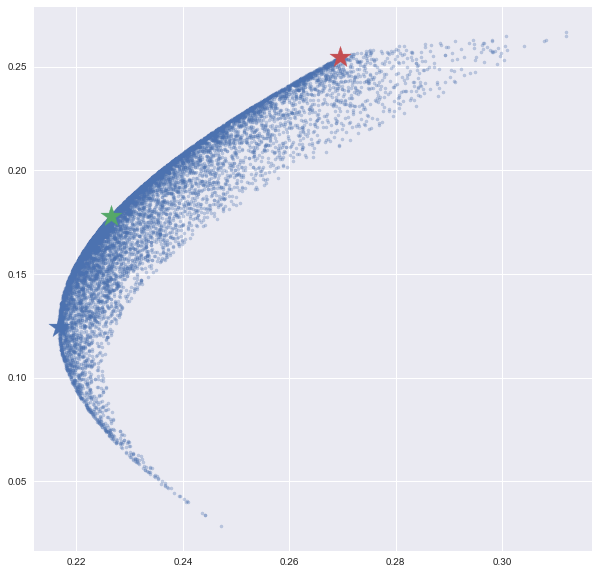

In [44]:
# Plot all simulated portfolios and mark the abovementioned 3 portfolios
plt.subplots(figsize=(10, 10))
plt.scatter(portfolios['Volatility'], portfolios['Return'],marker='o', s=10, alpha=0.3)
plt.scatter(optimal_port[1], optimal_port[0], color='r', marker='*', s=500)
plt.scatter(min_vol_port[1], min_vol_port[0], color='b', marker='*', s=500)
plt.scatter(equal_weight_port[1], equal_weight_port[0], color='g', marker='*', s=500)

The red star denotes the **optimal portfolio** that has the highest Sharpe Ratio. The blue star denotes the portfolio with minimum volatility. The green star denotes the portfolio where stocks are equally weighted.
> To have the maximum return at minimum risk, we should allocate weights of 46.91%, 0.01% and 53.07% for aapl, ibm and amzn respectively.

# Part 3: Portfolio Return Prediction

In this part, we use the weights of the optimal portfolio multiplied by the returns predicted to obtain the expected portfolio return for the next period (2022.5.17).

In [45]:
## Portfolio with highest Sharpe Ratio
predict_return_optimal = predict_aapl*optimal_port[2] + predict_ibm*optimal_port[3] + predict_amzn*optimal_port[4]
predict_return_optimal

-0.12433260484794464

> The predicted return of a portfolio with an optimal weights allocation on 2022-05-17 is -0.12.

In [46]:
## Portfolio with lowest risk
predict_return_min_vol = predict_aapl*min_vol_port[2] + predict_ibm*min_vol_port[3] + predict_amzn*min_vol_port[4]
predict_return_min_vol

-0.03018121342317886

> The predicted return of a portfolio with allocation with the lowest risk on 2022-05-17 is -0.03.

In [47]:
## Portfolio with equal weight
predict_return_equal_weight = predict_aapl*equal_weight_port[2] + predict_ibm*equal_weight_port[3] + predict_amzn*equal_weight_port[4]
predict_return_equal_weight

-0.06507215897242227

> The predicted return of a portfolio with equal weights assigned to each stock on 2022-05-17 is -0.06.

The above result only offers a prediction of portfolio return at 2022-05-17. We can change the end date to 'today' when importing the data to obtain a generic prediction of the next period.

Also, when choosing which stock should be included in the portfolio, future studies could apply other machine learning algorithms such as binary classification to predict whether a specific stock could outperform or underperform in the stock market.